In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

C:\Users\sergi\AppData\Local\Temp\ipykernel_8544\3755730.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #стиль отрисовки seaborn


In [3]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [5]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [6]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [7]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


**Hold-Out**

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


In [11]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [12]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


**K-Fold**

In [13]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [14]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [15]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Код с использованием функции cross_validate():

In [16]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02693081, 0.02393317, 0.02366877, 0.02232957, 0.02370882]),
 'score_time': array([0.00202417, 0.00196457, 0.00199556, 0.00099969, 0.00199485]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [17]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


**LEAVE-ONE-OUT**

In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


**Дисбаланс выборки**

0    0.60989
1    0.39011
Name: Potability, dtype: float64

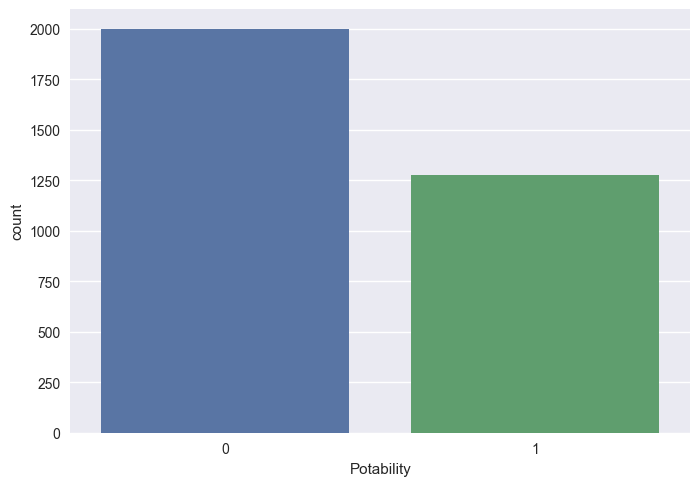

In [19]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

**СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ**

Обычное случайное разбиение:

In [20]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Стратифицированное разбиение:

In [21]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


Стратифицированное k-fold-разбиение:

In [22]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


**Выбор метрик в условиях дисбаланса классов**

In [23]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656

